# Batch correction in expression space

In this tutorial, we will train and evaluate a CPA model on the
Immune_ALL_human.h5ad dataset from [scib](https://github.com/theislab/scib) to perform batch correction, in gene expression space.

The following steps are going to be covered:
1. Setting up environment
2. Loading the dataset
3. Preprocessing the dataset
4. Creating a CPA model
5. Training the model
6. Latent space visualisation
7. Reconstructed gene expression space visualisation

In [1]:
import sys
#if branch is stable, will install via pypi, else will install from source
branch = "latest"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install cpa-tools
    !pip install scanpy
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install git+https://github.com/theislab/cpa
    !pip install scanpy

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
print("Current directory:", os.getcwd())
os.chdir("../..")
# Verify the new directory
print("New directory:", os.getcwd())
current_dir = os.getcwd()
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Current directory: /Users/jeriel/Documents/WS24:25/MA/cpa/docs/tutorials
New directory: /Users/jeriel/Documents/WS24:25/MA/cpa


In [4]:
import cpa
import scanpy as sc
import gdown
from anndata import AnnData

Global seed set to 0


In [5]:
sc.settings.set_figure_params(dpi=100)

## Loading dataset

This dataset with `h5ad` extension used for saving/loading anndata objects is publicly available in the [Google Drive](https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC) and can be downloaded using `gdown` and then loaded using the `sc.read` function.

In [6]:
url = 'https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC'
output = 'pbmc.h5ad'
gdown.download(url, output, quiet=False)

FileURLRetrievalError: Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC

but Gdown can't. Please check connections and permissions.

In [ ]:
adata = sc.read('pbmc.h5ad')

We are removing the `Villani` batch of the dataset since we want to work with the count data and this batch does not contain the counts.

In [ ]:
adata = adata[~(adata.obs['batch'] == 'Villani')]

In [ ]:
adata

View of AnnData object with n_obs × n_vars = 32484 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [ ]:
adata.obs['batch'].value_counts()

10X               10727
Oetjen_U           3730
Freytag            3347
Oetjen_P           3265
Oetjen_A           2586
Sun_sample4_TC     2420
Sun_sample3_TB     2403
Sun_sample2_KC     2281
Sun_sample1_CS     1725
Name: batch, dtype: int64

In [ ]:
adata.obs['final_annotation'].value_counts()

CD4+ T cells                        11011
CD14+ Monocytes                      6338
CD20+ B cells                        2873
NKT cells                            2745
NK cells                             2294
CD8+ T cells                         2183
Erythrocytes                         1502
CD16+ Monocytes                       825
Monocyte-derived dendritic cells      478
HSPCs                                 473
Erythroid progenitors                 463
Monocyte progenitors                  428
Megakaryocyte progenitors             270
Plasmacytoid dendritic cells          265
CD10+ B cells                         207
Plasma cells                          129
Name: final_annotation, dtype: int64

## Normalization & HVG selection
We normalize the dataset and select the top 5000 highly variable genes from all the 12303 genes in the dataset.

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    batch_key="batch",
    subset=True)

In [ ]:
adata

AnnData object with n_obs × n_vars = 32484 × 5000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [ ]:
adata.obs

batch chemistry data_type  \
index                                                                   
AAACCTGCAGCGAACA-1-Oetjen_A              Oetjen_A    v2_10X       UMI   
AAACCTGCATGTCCTC-1-Oetjen_A              Oetjen_A    v2_10X       UMI   
AAACCTGGTCGACTGC-1-Oetjen_A              Oetjen_A    v2_10X       UMI   
AAACCTGGTCGCTTCT-1-Oetjen_A              Oetjen_A    v2_10X       UMI   
AAACCTGTCCCGACTT-1-Oetjen_A              Oetjen_A    v2_10X       UMI   
...                                           ...       ...       ...   
TTTGTCAAGCTCCTTC-1-Sun_sample4_TC  Sun_sample4_TC       10X       UMI   
TTTGTCAAGCTGAAAT-1-Sun_sample4_TC  Sun_sample4_TC       10X       UMI   
TTTGTCATCATCATTC-1-Sun_sample4_TC  Sun_sample4_TC       10X       UMI   
TTTGTCATCTCGCTTG-1-Sun_sample4_TC  Sun_sample4_TC       10X       UMI   
TTTGTCATCTGTCTCG-1-Sun_sample4_TC  Sun_sample4_TC       10X       UMI   

                                   dpt_pseudotime final_annotation   mt_frac  \
index                                                                          
AAACCTGCAGCGAACA-1-Oetjen_A                   NaN  CD16+ Monocytes  0.047970   
AAACCTGCATGTCCTC-1-Oetjen_A                   NaN     CD4+ T cells  0.024928   
AAACCTGGTCGACTGC-1-Oetjen_A                   NaN  CD14+ Monocytes  0.051907   
AAACCTGGTCGCTTCT-1-Oetjen_A                   NaN  CD14+ Monocytes  0.041716   
AAACCTGTCCCGACTT-1-Oetjen_A                   NaN        NKT cells  0.043522   
...                                           ...              ...       ...   
TTTGTCAAGCTCCTTC-1-Sun_sample4_TC             NaN  CD14+ Monocytes  0.059215   
TTTGTCAAGCTGAAAT-1-Sun_sample4_TC             NaN  CD14+ Monocytes  0.051119   
TTTGTCATCATCATTC-1-Sun_sample4_TC             NaN         NK cells  0.038078   
TTTGTCATCTCGCTTG-1-Sun_sample4_TC             NaN         NK cells  0.052873   
TTTGTCATCTGTCTCG-1-Sun_sample4_TC             NaN     CD4+ T cells  0.019406   

                                   n_counts  n_genes sample_ID  size_factors  \
index                                                                          
AAACCTGCAGCGAACA-1-Oetjen_A          6379.0   1862.0         0      0.957719   
AAACCTGCATGTCCTC-1-Oetjen_A          4172.0   1082.0         0      0.425532   
AAACCTGGTCGACTGC-1-Oetjen_A          6608.0   1618.0         0      0.773111   
AAACCTGGTCGCTTCT-1-Oetjen_A          5034.0   1413.0         0      0.641188   
AAACCTGTCCCGACTT-1-Oetjen_A          3998.0   1127.0         0      0.452426   
...                                     ...      ...       ...           ...   
TTTGTCAAGCTCCTTC-1-Sun_sample4_TC    3006.0   1111.0         3      0.825529   
TTTGTCAAGCTGAAAT-1-Sun_sample4_TC    5810.0   1723.0         3      1.584353   
TTTGTCATCATCATTC-1-Sun_sample4_TC    2705.0   1209.0         3      0.978014   
TTTGTCATCTCGCTTG-1-Sun_sample4_TC    2837.0   1045.0         3      0.793495   
TTTGTCATCTGTCTCG-1-Sun_sample4_TC    3504.0    915.0         3      0.677142   

                                  species   study       tissue  
index                                                           
AAACCTGCAGCGAACA-1-Oetjen_A         Human  Oetjen  Bone_Marrow  
AAACCTGCATGTCCTC-1-Oetjen_A         Human  Oetjen  Bone_Marrow  
AAACCTGGTCGACTGC-1-Oetjen_A         Human  Oetjen  Bone_Marrow  
AAACCTGGTCGCTTCT-1-Oetjen_A         Human  Oetjen  Bone_Marrow  
AAACCTGTCCCGACTT-1-Oetjen_A         Human  Oetjen  Bone_Marrow  
...                                   ...     ...          ...  
TTTGTCAAGCTCCTTC-1-Sun_sample4_TC   Human     Sun        PBMCs  
TTTGTCAAGCTGAAAT-1-Sun_sample4_TC   Human     Sun        PBMCs  
TTTGTCATCATCATTC-1-Sun_sample4_TC   Human     Sun        PBMCs  
TTTGTCATCTCGCTTG-1-Sun_sample4_TC   Human     Sun        PBMCs  
TTTGTCATCTGTCTCG-1-Sun_sample4_TC   Human     Sun        PBMCs  

[32484 rows x 13 columns]

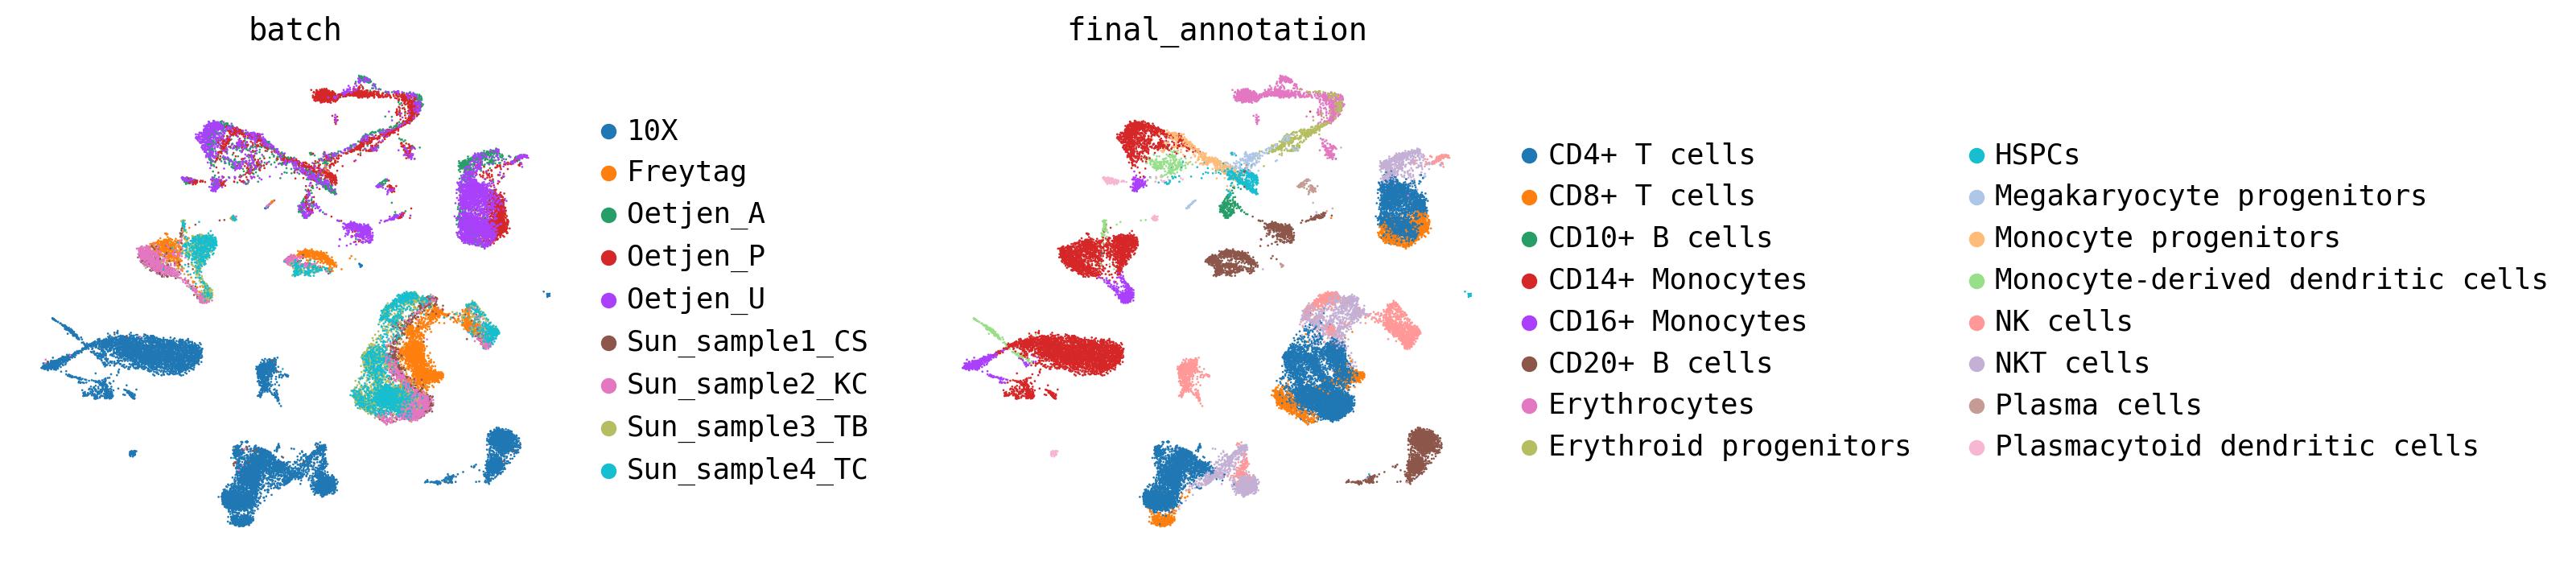

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(adata,
           color=['batch', 'final_annotation'],
           frameon=False,
           wspace=0.5)

## Cell type annotation
We create a new column in `adata.obs` and copy the `final_annotation` column there, removing the `+` characters in the names. (`+` is used for processing combinatorial perturbations in CPA)

In [ ]:
adata.obs['cell_type'] = 'NaN'
for cell_type in adata.obs['final_annotation'].unique():
    adata.obs.loc[adata.obs['final_annotation'] == cell_type, 'cell_type'] = cell_type.replace('+', '')

In [ ]:
adata.obs.head()

batch chemistry data_type  dpt_pseudotime  \
index                                                                       
AAACCTGCAGCGAACA-1-Oetjen_A  Oetjen_A    v2_10X       UMI             NaN   
AAACCTGCATGTCCTC-1-Oetjen_A  Oetjen_A    v2_10X       UMI             NaN   
AAACCTGGTCGACTGC-1-Oetjen_A  Oetjen_A    v2_10X       UMI             NaN   
AAACCTGGTCGCTTCT-1-Oetjen_A  Oetjen_A    v2_10X       UMI             NaN   
AAACCTGTCCCGACTT-1-Oetjen_A  Oetjen_A    v2_10X       UMI             NaN   

                            final_annotation   mt_frac  n_counts  n_genes  \
index                                                                       
AAACCTGCAGCGAACA-1-Oetjen_A  CD16+ Monocytes  0.047970    6379.0   1862.0   
AAACCTGCATGTCCTC-1-Oetjen_A     CD4+ T cells  0.024928    4172.0   1082.0   
AAACCTGGTCGACTGC-1-Oetjen_A  CD14+ Monocytes  0.051907    6608.0   1618.0   
AAACCTGGTCGCTTCT-1-Oetjen_A  CD14+ Monocytes  0.041716    5034.0   1413.0   
AAACCTGTCCCGACTT-1-Oetjen_A        NKT cells  0.043522    3998.0   1127.0   

                            sample_ID  size_factors species   study  \
index                                                                 
AAACCTGCAGCGAACA-1-Oetjen_A         0      0.957719   Human  Oetjen   
AAACCTGCATGTCCTC-1-Oetjen_A         0      0.425532   Human  Oetjen   
AAACCTGGTCGACTGC-1-Oetjen_A         0      0.773111   Human  Oetjen   
AAACCTGGTCGCTTCT-1-Oetjen_A         0      0.641188   Human  Oetjen   
AAACCTGTCCCGACTT-1-Oetjen_A         0      0.452426   Human  Oetjen   

                                  tissue       cell_type  
index                                                     
AAACCTGCAGCGAACA-1-Oetjen_A  Bone_Marrow  CD16 Monocytes  
AAACCTGCATGTCCTC-1-Oetjen_A  Bone_Marrow     CD4 T cells  
AAACCTGGTCGACTGC-1-Oetjen_A  Bone_Marrow  CD14 Monocytes  
AAACCTGGTCGCTTCT-1-Oetjen_A  Bone_Marrow  CD14 Monocytes  
AAACCTGTCCCGACTT-1-Oetjen_A  Bone_Marrow       NKT cells

Next, we just replace `adata.X` with raw counts to be able to train CPA with Negative Binomial (NB) or Zero-Inflated Negative Binomial (ZINB) loss.

In [ ]:
adata.X = adata.layers["counts"].copy()

## Dataset setup
Now is the time to setup the dataset for CPA to prepare the dataset for training. Just like scvi-tools models, you can call `cpa.CPA.setup_anndata` to setup your data. Although, we will use the `setup_anndata` arguments a bit different than our previous tutorials, since we arent' dealing with a perturbation dataset here. We are dealing with batch effect of different sources and cell types.
 This function will accept the following arguments:

- `adata`: AnnData object containing the data to be preprocessed
- `perturbation_key`: The key in `adata.obs` that contains the perturbation information (In this notebook's case, we provide `batch` as our perturbation)
- `control_group`: The name of the control group in `perturbation_key` (In this notebook's case, we provide one of the batch groups as our control group)
- `batch_key`: The key in `adata.obs` that contains the batch information (We are not providing any batch key here)
- `dosage_key`: The key in `adata.obs` that contains the dosage information
- `categorical_covariate_keys`: A list of keys in `adata.obs` that contain categorical covariates
- `is_count_data`: Whether the `adata.X` is count data or not
- `deg_uns_key`: The key in `adata.uns` that contains the differential expression results
- `deg_uns_cat_key`: The key in `adata.obs` that contains the category information of each cell which can be used as to access differential expression results in `adata.uns[deg_uns_key]`. For example, if `deg_uns_key` is `rank_genes_groups_cov` and `deg_uns_cat_key` is `cov_cond`, then `adata.uns[deg_uns_key][cov_cond]` will contain the differential expression results for each category in `cov_cond`.
- `max_comb_len`: The maximum number of perturbations that are applied to each cell. For example, if `max_comb_len` is 2, then the model will be trained to predict the effect of single perturbations and the effect of double perturbations.

### Further explanation:
We will use the function `custom_predict` later in this notebook, which accepts customized covariate keys as input, and will return a customized reconstructed gene expression, containing just the covariates you specified to you.
For example, we could have multiple keys in `categorical_covariate_keys` here, and only add the `cell_type` effect to the gene expression reconstruction process.

In [ ]:
cpa.CPA.setup_anndata(adata,
                      perturbation_key='batch',
                      control_group='Sun_sample1_CS',
                      categorical_covariate_keys=['cell_type'],
                      is_count_data=True,
                      max_comb_len=1,
                     )

100%|██████████| 32484/32484 [00:00<00:00, 842559.51it/s]


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [ ]:
model_params = {
    "n_latent": 64,
    "recon_loss": "nb",
    "doser_type": "linear",
    "n_hidden_encoder": 128,
    "n_layers_encoder": 2,
    "n_hidden_decoder": 512,
    "n_layers_decoder": 2,
    "use_batch_norm_encoder": True,
    "use_layer_norm_encoder": False,
    "use_batch_norm_decoder": False,
    "use_layer_norm_decoder": True,
    "dropout_rate_encoder": 0.0,
    "dropout_rate_decoder": 0.1,
    "variational": False,
    "seed": 6977,
}

trainer_params = {
    "n_epochs_kl_warmup": None,
    "n_epochs_pretrain_ae": 30,
    "n_epochs_adv_warmup": 50,
    "n_epochs_mixup_warmup": 0,
    "mixup_alpha": 0.0,
    "adv_steps": None,
    "n_hidden_adv": 64,
    "n_layers_adv": 3,
    "use_batch_norm_adv": True,
    "use_layer_norm_adv": False,
    "dropout_rate_adv": 0.3,
    "reg_adv": 20.0,
    "pen_adv": 5.0,
    "lr": 0.0003,
    "wd": 4e-07,
    "adv_lr": 0.0003,
    "adv_wd": 4e-07,
    "adv_loss": "cce",
    "doser_lr": 0.0003,
    "doser_wd": 4e-07,
    "do_clip_grad": True,
    "gradient_clip_value": 1.0,
    "step_size_lr": 10,
}

## CPA Model

You can create a CPA model by creating an object from `cpa.CPA` class. The constructor of this class takes the following arguments:
**Data related parameters:**
- `adata`: AnnData object containing train/valid/test data
- Optional:
    - `split_key`: The key in `adata.obs` that contains the split information
    - `train_split`: The value in `split_key` that corresponds to the training data
    - `valid_split`: The value in `split_key` that corresponds to the validation data
    - `test_split`: The value in `split_key` that corresponds to the test data

**Model architecture parameters:**
- `n_latent`: Number of latent dimensions
- `recon_loss`: Reconstruction loss function. Currently, Supported losses are `nb`, `zinb`, and `gauss`.
- `n_hidden_encoder`: Number of hidden units in the encoder
- `n_layers_encoder`: Number of layers in the encoder
- `n_hidden_decoder`: Number of hidden units in the decoder
- `n_layers_decoder`: Number of layers in the decoder
- `use_batch_norm_encoder`: Whether to use batch normalization in the encoder
- `use_layer_norm_encoder`: Whether to use layer normalization in the encoder
- `use_batch_norm_decoder`: Whether to use batch normalization in the decoder
- `use_layer_norm_decoder`: Whether to use layer normalization in the decoder
- `dropout_rate_encoder`: Dropout rate in the encoder
- `dropout_rate_decoder`: Dropout rate in the decoder
- `variational`: Whether to use variational inference. NOTE: False is highly recommended.
- `seed`: Random seed

In [ ]:
model = cpa.CPA(adata=adata,
                **model_params,
               )

INFO:lightning_fabric.utilities.seed:Global seed set to 6977


## Training CPA

In order to train your CPA model, you need to use `train` function of your `model`. This function accepts the following parameters:
- `max_epochs`: Maximum number of epochs to train the model. CPA generally converges after high number of epochs, so you can set this to a high value.
- `use_gpu`: If you have a GPU, you can set this to `True` to speed up the training process.
- `batch_size`: Batch size for training. You can set this to a high value (e.g. 512, 1024, 2048) if you have a GPU.
- `plan_kwargs`: dictionary of parameters passed the CPA's `TrainingPlan`. You can set the following parameters:
    * `n_epochs_adv_warmup`: Number of epochs to linearly increase the weight of adversarial loss.
    * `n_epochs_mixup_warmup`: Number of epochs to linearly increase the weight of mixup loss.
    * `n_epochs_pretrain_ae`: Number of epochs to pretrain the autoencoder.
    * `lr`: Learning rate for training autoencoder.
    * `wd`: Weight decay for training autoencoder.
    * `adv_lr`: Learning rate for training adversary.
    * `adv_wd`: Weight decay for training adversary.
    * `adv_steps`: Number of steps to train adversary for each step of autoencoder.
    * `reg_adv`: Maximum Weight of adversarial loss.
    * `pen_adv`: Penalty weight of adversarial loss.
    * `n_layers_adv`: Number of layers in adversary.
    * `n_hidden_adv`: Number of hidden units in adversary.
    * `use_batch_norm_adv`: Whether to use batch normalization in adversary.
    * `use_layer_norm_adv`: Whether to use layer normalization in adversary.
    * `dropout_rate_adv`: Dropout rate in adversary.
    * `step_size_lr`: Step size for learning rate scheduler.
    * `do_clip_grad`: Whether to clip gradients by norm.
    * `clip_grad_value`: Maximum value of gradient norm.
    * `adv_loss`: Type of adversarial loss. Can be either `cce` for Cross Entropy loss or `focal` for Focal loss.
    * `n_epochs_verbose`: Number of epochs to print latent information disentanglement evaluation.
- `early_stopping_patience`: Number of epochs to wait before stopping training if validation metric does not improve.
- `check_val_every_n_epoch`: Number of epochs to wait before running validation.
- `save_path`: Path to save the best model after training.



In [ ]:
model.train(max_epochs=2000,
            use_gpu=True,
            batch_size=512,
            plan_kwargs=trainer_params,
            early_stopping_patience=5,
            check_val_every_n_epoch=5,
            save_path='pbmc',
           )

100%|██████████| 9/9 [00:00<00:00, 221.48it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 5/2000:   0%|          | 4/2000 [00:45<5:58:50, 10.79s/it, v_num=1, recon=1.51e+3, r2_mean=0.864, adv_loss=2.62, acc_pert=0.368, acc_cell_type=0.742]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/2000:   0%|          | 9/2000 [01:37<5:44:12, 10.37s/it, v_num=1, recon=1.48e+3, r2_mean=0.878, adv_loss=1.93, acc_pert=0.487, acc_cell_type=0.82, val_recon=1.51e+3, disnt_basal=0.568, disnt_after=0.955, val_r2_mean=0.869, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5448514444994996
disnt_after = 0.9445390274801598
val_r2_mean = 0.8720472641229867
val_r2_var = 0.09845181248106927
Epoch 15/2000:   1%|          | 14/2000 [02:29<5:41:36, 10.32s/it, v_num=1, recon=1.47e+3, r2_mean=0.881, adv_loss=1.75, acc_pert=0.518, acc_cell_type=0.843, val_recon=1.49e+3, disnt_basal=0.545, disnt_after=0.945, val_r2_mean=0.872, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/2000:   1%|          | 19/2000 [03:22<5:40:50, 10.32s/it, v_num=1, recon=1.46e+3, r2_mean=0.884, adv_loss=1.67, acc_pert=0.544, acc_cell_type=0.852, val_recon=1.48e+3, disnt_basal=0.532, disnt_after=0.947, val_r2_mean=0.876, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5205889237841945
disnt_after = 0.9460166770555568
val_r2_mean = 0.8740344239683918
val_r2_var = 0.1307928459024178
Epoch 25/2000:   1%|          | 24/2000 [04:14<5:37:47, 10.26s/it, v_num=1, recon=1.45e+3, r2_mean=0.886, adv_loss=1.64, acc_pert=0.55, acc_cell_type=0.853, val_recon=1.47e+3, disnt_basal=0.521, disnt_after=0.946, val_r2_mean=0.874, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/2000:   1%|▏         | 29/2000 [05:05<5:35:18, 10.21s/it, v_num=1, recon=1.44e+3, r2_mean=0.886, adv_loss=1.63, acc_pert=0.553, acc_cell_type=0.855, val_recon=1.47e+3, disnt_basal=0.512, disnt_after=0.947, val_r2_mean=0.873, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5076468764706341
disnt_after = 0.9466299326623039
val_r2_mean = 0.8651580931837479
val_r2_var = 0.15397703331526572
Epoch 35/2000:   2%|▏         | 34/2000 [05:58<5:41:25, 10.42s/it, v_num=1, recon=1.43e+3, r2_mean=0.888, adv_loss=2.59, acc_pert=0.291, acc_cell_type=0.816, val_recon=1.47e+3, disnt_basal=0.508, disnt_after=0.947, val_r2_mean=0.865, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/2000:   2%|▏         | 39/2000 [06:51<5:42:29, 10.48s/it, v_num=1, recon=1.43e+3, r2_mean=0.887, adv_loss=4.44, acc_pert=0.162, acc_cell_type=0.32, val_recon=1.47e+3, disnt_basal=0.435, disnt_after=0.944, val_r2_mean=0.869, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00039: cpa_metric reached. Module best state updated.



disnt_basal = 0.3046657369884609
disnt_after = 0.9722530237624999
val_r2_mean = 0.869348135356906
val_r2_var = 0.13758454873804646
Epoch 45/2000:   2%|▏         | 44/2000 [07:44<5:43:36, 10.54s/it, v_num=1, recon=1.42e+3, r2_mean=0.887, adv_loss=4.18, acc_pert=0.144, acc_cell_type=0.339, val_recon=1.47e+3, disnt_basal=0.305, disnt_after=0.972, val_r2_mean=0.869, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00044: cpa_metric reached. Module best state updated.


Epoch 50/2000:   2%|▏         | 49/2000 [08:37<5:40:52, 10.48s/it, v_num=1, recon=1.42e+3, r2_mean=0.888, adv_loss=4.23, acc_pert=0.134, acc_cell_type=0.341, val_recon=1.46e+3, disnt_basal=0.255, disnt_after=0.972, val_r2_mean=0.87, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00049: cpa_metric reached. Module best state updated.



disnt_basal = 0.2375361001703719
disnt_after = 0.9755449343449495
val_r2_mean = 0.8706448694833104
val_r2_var = 0.13681865594511702
Epoch 55/2000:   3%|▎         | 54/2000 [09:30<5:39:18, 10.46s/it, v_num=1, recon=1.41e+3, r2_mean=0.889, adv_loss=4.25, acc_pert=0.14, acc_cell_type=0.342, val_recon=1.46e+3, disnt_basal=0.238, disnt_after=0.976, val_r2_mean=0.871, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00054: cpa_metric reached. Module best state updated.


Epoch 60/2000:   3%|▎         | 59/2000 [10:24<5:40:28, 10.52s/it, v_num=1, recon=1.4e+3, r2_mean=0.888, adv_loss=4.26, acc_pert=0.129, acc_cell_type=0.342, val_recon=1.46e+3, disnt_basal=0.22, disnt_after=0.974, val_r2_mean=0.865, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00059: cpa_metric reached. Module best state updated.



disnt_basal = 0.21553702792509893
disnt_after = 0.9755623916861279
val_r2_mean = 0.8670250636674555
val_r2_var = 0.13975838296138948
Epoch 65/2000:   3%|▎         | 64/2000 [11:17<5:39:27, 10.52s/it, v_num=1, recon=1.4e+3, r2_mean=0.89, adv_loss=4.27, acc_pert=0.127, acc_cell_type=0.342, val_recon=1.46e+3, disnt_basal=0.216, disnt_after=0.976, val_r2_mean=0.867, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00064: cpa_metric reached. Module best state updated.


Epoch 70/2000:   3%|▎         | 69/2000 [12:10<5:36:58, 10.47s/it, v_num=1, recon=1.39e+3, r2_mean=0.89, adv_loss=4.27, acc_pert=0.125, acc_cell_type=0.34, val_recon=1.46e+3, disnt_basal=0.211, disnt_after=0.977, val_r2_mean=0.868, val_KL=nan]
disnt_basal = 0.2084672843265242
disnt_after = 0.9739758383024988
val_r2_mean = 0.8676861214678137
val_r2_var = 0.13804587045675404
Epoch 75/2000:   4%|▎         | 74/2000 [13:03<5:34:26, 10.42s/it, v_num=1, recon=1.39e+3, r2_mean=0.892, adv_loss=4.27, acc_pert=0.124, acc_cell_type=0.341, val_recon=1.46e+3, disnt_basal=0.208, disnt_after=0.974, val_r2_mean=0.868, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00074: cpa_metric reached. Module best state updated.


Epoch 80/2000:   4%|▍         | 79/2000 [13:56<5:35:08, 10.47s/it, v_num=1, recon=1.39e+3, r2_mean=0.89, adv_loss=4.27, acc_pert=0.122, acc_cell_type=0.341, val_recon=1.46e+3, disnt_basal=0.207, disnt_after=0.974, val_r2_mean=0.868, val_KL=nan]
disnt_basal = 0.20866478889040183
disnt_after = 0.9768478580883292
val_r2_mean = 0.8662142774381086
val_r2_var = 0.14127867269839967
Epoch 85/2000:   4%|▍         | 84/2000 [14:49<5:34:56, 10.49s/it, v_num=1, recon=1.38e+3, r2_mean=0.891, adv_loss=4.27, acc_pert=0.121, acc_cell_type=0.341, val_recon=1.46e+3, disnt_basal=0.209, disnt_after=0.977, val_r2_mean=0.866, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00084: cpa_metric reached. Module best state updated.


Epoch 90/2000:   4%|▍         | 89/2000 [15:42<5:32:36, 10.44s/it, v_num=1, recon=1.38e+3, r2_mean=0.891, adv_loss=4.27, acc_pert=0.123, acc_cell_type=0.338, val_recon=1.46e+3, disnt_basal=0.203, disnt_after=0.977, val_r2_mean=0.868, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00089: cpa_metric reached. Module best state updated.



disnt_basal = 0.1993702259993765
disnt_after = 0.9733417191679165
val_r2_mean = 0.8647374988082042
val_r2_var = 0.14449807734640396
Epoch 95/2000:   5%|▍         | 94/2000 [16:35<5:31:38, 10.44s/it, v_num=1, recon=1.37e+3, r2_mean=0.893, adv_loss=4.27, acc_pert=0.126, acc_cell_type=0.341, val_recon=1.46e+3, disnt_basal=0.199, disnt_after=0.973, val_r2_mean=0.865, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00094: cpa_metric reached. Module best state updated.


Epoch 100/2000:   5%|▍         | 99/2000 [17:27<5:28:59, 10.38s/it, v_num=1, recon=1.37e+3, r2_mean=0.892, adv_loss=4.26, acc_pert=0.132, acc_cell_type=0.341, val_recon=1.46e+3, disnt_basal=0.201, disnt_after=0.976, val_r2_mean=0.864, val_KL=nan]
disnt_basal = 0.20001312060601423
disnt_after = 0.9742098666068058
val_r2_mean = 0.8638746776485495
val_r2_var = 0.14524318851054388
Epoch 105/2000:   5%|▌         | 104/2000 [18:20<5:29:23, 10.42s/it, v_num=1, recon=1.36e+3, r2_mean=0.893, adv_loss=4.26, acc_pert=0.126, acc_cell_type=0.34, val_recon=1.46e+3, disnt_basal=0.2, disnt_after=0.974, val_r2_mean=0.864, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00104: cpa_metric reached. Module best state updated.


Epoch 110/2000:   5%|▌         | 109/2000 [19:13<5:29:25, 10.45s/it, v_num=1, recon=1.36e+3, r2_mean=0.895, adv_loss=4.25, acc_pert=0.127, acc_cell_type=0.342, val_recon=1.46e+3, disnt_basal=0.198, disnt_after=0.974, val_r2_mean=0.865, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00109: cpa_metric reached. Module best state updated.



disnt_basal = 0.19625689866298165
disnt_after = 0.9756935412066419
val_r2_mean = 0.865244704455907
val_r2_var = 0.14554889155115994
Epoch 120/2000:   6%|▌         | 119/2000 [20:59<5:27:33, 10.45s/it, v_num=1, recon=1.36e+3, r2_mean=0.894, adv_loss=4.25, acc_pert=0.135, acc_cell_type=0.342, val_recon=1.46e+3, disnt_basal=0.197, disnt_after=0.976, val_r2_mean=0.865, val_KL=nan]
disnt_basal = 0.19492465288804825
disnt_after = 0.9739763185283543
val_r2_mean = 0.8640360988883471
val_r2_var = 0.1449822902385305
Epoch 125/2000:   6%|▌         | 124/2000 [21:51<5:25:46, 10.42s/it, v_num=1, recon=1.35e+3, r2_mean=0.894, adv_loss=4.25, acc_pert=0.132, acc_cell_type=0.342, val_recon=1.46e+3, disnt_basal=0.195, disnt_after=0.974, val_r2_mean=0.864, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00124: cpa_metric reached. Module best state updated.


Epoch 130/2000:   6%|▋         | 129/2000 [22:44<5:25:19, 10.43s/it, v_num=1, recon=1.35e+3, r2_mean=0.894, adv_loss=4.25, acc_pert=0.133, acc_cell_type=0.342, val_recon=1.46e+3, disnt_basal=0.193, disnt_after=0.974, val_r2_mean=0.866, val_KL=nan]
disnt_basal = 0.19412101922400948
disnt_after = 0.9742961476812232
val_r2_mean = 0.8616686939069214
val_r2_var = 0.14811435084740165
Epoch 140/2000:   7%|▋         | 139/2000 [24:32<5:26:35, 10.53s/it, v_num=1, recon=1.34e+3, r2_mean=0.893, adv_loss=4.25, acc_pert=0.138, acc_cell_type=0.343, val_recon=1.46e+3, disnt_basal=0.192, disnt_after=0.974, val_r2_mean=0.865, val_KL=nan]
disnt_basal = 0.19588380671008282
disnt_after = 0.9715736748335113
val_r2_mean = 0.8644040614526485
val_r2_var = 0.14778422549205242
Epoch 150/2000:   7%|▋         | 149/2000 [26:19<5:26:09, 10.57s/it, v_num=1, recon=1.34e+3, r2_mean=0.893, adv_loss=4.25, acc_pert=0.14, acc_cell_type=0.343, val_recon=1.46e+3, disnt_basal=0.194, disnt_after=0.975, val_r2_mean=0.862, val

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00149: cpa_metric reached. Module best state updated.



disnt_basal = 0.18993152592509335
disnt_after = 0.9725659938460953
val_r2_mean = 0.8632550071111121
val_r2_var = 0.14692161657002828
Epoch 155/2000:   8%|▊         | 154/2000 [27:12<5:25:34, 10.58s/it, v_num=1, recon=1.34e+3, r2_mean=0.894, adv_loss=4.24, acc_pert=0.137, acc_cell_type=0.34, val_recon=1.46e+3, disnt_basal=0.19, disnt_after=0.973, val_r2_mean=0.863, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00154: cpa_metric reached. Module best state updated.


Epoch 160/2000:   8%|▊         | 159/2000 [28:05<5:22:37, 10.51s/it, v_num=1, recon=1.34e+3, r2_mean=0.895, adv_loss=4.24, acc_pert=0.137, acc_cell_type=0.341, val_recon=1.47e+3, disnt_basal=0.19, disnt_after=0.972, val_r2_mean=0.863, val_KL=nan]
disnt_basal = 0.19149569085339685
disnt_after = 0.9712946793693985
val_r2_mean = 0.8621539782032516
val_r2_var = 0.14774785195887838
Epoch 170/2000:   8%|▊         | 169/2000 [29:52<5:20:37, 10.51s/it, v_num=1, recon=1.33e+3, r2_mean=0.894, adv_loss=4.23, acc_pert=0.14, acc_cell_type=0.343, val_recon=1.47e+3, disnt_basal=0.188, disnt_after=0.97, val_r2_mean=0.864, val_KL=nan]
disnt_basal = 0.19083305336285936
disnt_after = 0.9701256588429791
val_r2_mean = 0.8638972209972612
val_r2_var = 0.145721983120096
Epoch 180/2000:   9%|▉         | 179/2000 [31:39<5:19:49, 10.54s/it, v_num=1, recon=1.33e+3, r2_mean=0.894, adv_loss=4.24, acc_pert=0.139, acc_cell_type=0.342, val_recon=1.47e+3, disnt_basal=0.19, disnt_after=0.971, val_r2_mean=0.863, val_KL=n

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00179: cpa_metric reached. Module best state updated.



disnt_basal = 0.18974742903708766
disnt_after = 0.972303123090329
val_r2_mean = 0.8639202541450055
val_r2_var = 0.14711585542777567
Epoch 185/2000:   9%|▉         | 184/2000 [32:32<5:17:49, 10.50s/it, v_num=1, recon=1.33e+3, r2_mean=0.895, adv_loss=4.23, acc_pert=0.139, acc_cell_type=0.343, val_recon=1.47e+3, disnt_basal=0.19, disnt_after=0.972, val_r2_mean=0.864, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00184: cpa_metric reached. Module best state updated.


Epoch 190/2000:   9%|▉         | 189/2000 [33:25<5:15:52, 10.47s/it, v_num=1, recon=1.32e+3, r2_mean=0.895, adv_loss=4.24, acc_pert=0.142, acc_cell_type=0.341, val_recon=1.47e+3, disnt_basal=0.188, disnt_after=0.974, val_r2_mean=0.862, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00189: cpa_metric reached. Module best state updated.



disnt_basal = 0.18642140030367155
disnt_after = 0.9725807425562701
val_r2_mean = 0.8625523437648852
val_r2_var = 0.14924209534003127
Epoch 200/2000:  10%|▉         | 199/2000 [35:11<5:12:59, 10.43s/it, v_num=1, recon=1.32e+3, r2_mean=0.895, adv_loss=4.23, acc_pert=0.134, acc_cell_type=0.342, val_recon=1.47e+3, disnt_basal=0.188, disnt_after=0.971, val_r2_mean=0.863, val_KL=nan]
disnt_basal = 0.1875488074250268
disnt_after = 0.9708676739093677
val_r2_mean = 0.8638683565428585
val_r2_var = 0.1481757655410596
Epoch 210/2000:  10%|█         | 209/2000 [36:58<5:14:35, 10.54s/it, v_num=1, recon=1.32e+3, r2_mean=0.896, adv_loss=4.23, acc_pert=0.138, acc_cell_type=0.344, val_recon=1.47e+3, disnt_basal=0.187, disnt_after=0.971, val_r2_mean=0.862, val_KL=nan]
disnt_basal = 0.18732250878038184
disnt_after = 0.97106076903915
val_r2_mean = 0.8627997914116401
val_r2_var = 0.14641333093030975
Epoch 215/2000:  11%|█         | 215/2000 [38:03<5:15:55, 10.62s/it, v_num=1, recon=1.32e+3, r2_mean=0.896, 

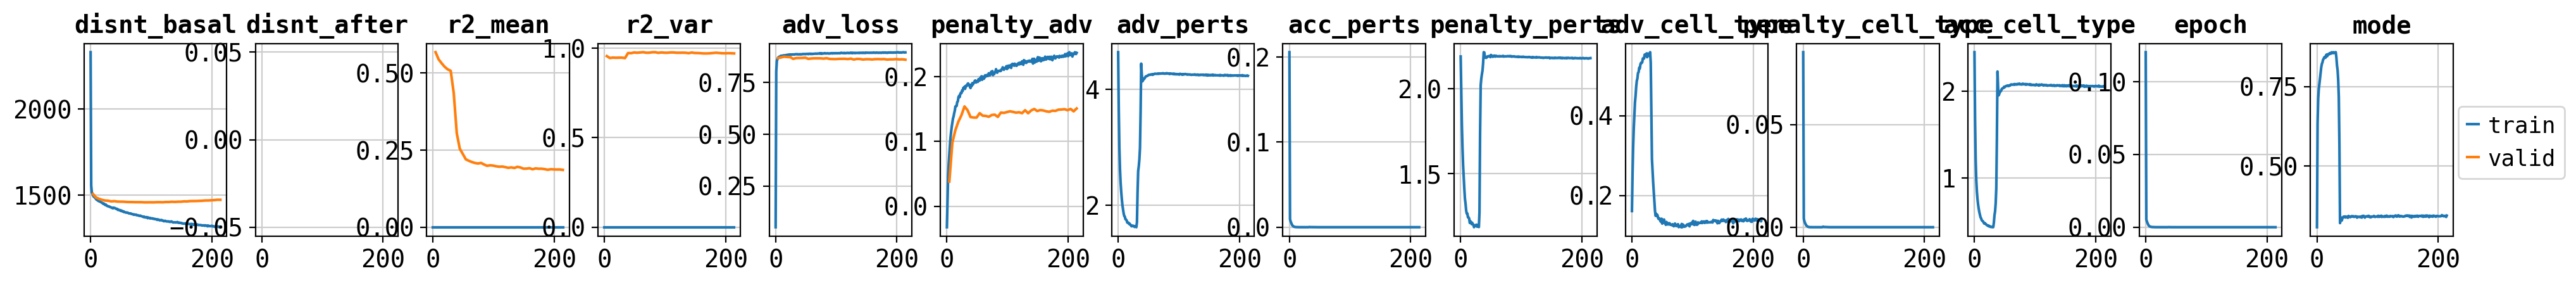

In [ ]:
cpa.pl.plot_history(model)

## Restore best model

In case you have already saved your pretrained model, you can restore it using the following code. The `cpa.CPA.load` function accepts the following arguments:
- `dir_path`: path to the directory where the model is saved
- `adata`: anndata object
- `use_gpu`: whether to use GPU or not

In [ ]:
# model = cpa.CPA.load(dir_path='pbmc/',
#                      adata=adata,
#                      use_gpu=True)

## Latent and gene expression prediction

### `model.custom_predict`:
```
Predicts the output of the model on the given input data.

Args:
    covars_to_add (Optional[Sequence[str]]): List of covariates to add to the basal latent representation.
    basal (bool): Whether to use just the basal latent representation. If True, `add_batch` and `add_pert` are ignored.
    add_batch (bool): Whether to add the batch covariate to the latent representation.
    add_pert (bool): Whether to add the perturbation covariate to the latent representation.
    adata (Optional[AnnData]): The input data to predict on.
    indices (Optional[Sequence[int]]): The indices of the cells to predict on.
    batch_size (Optional[int]): The batch size to use for prediction.
    n_samples (int): The number of samples to use for stochastic prediction.
    return_mean (bool): Whether to return the mean of the samples or all the samples.

Returns:
    latent_outputs (AnnData): A dictionary of AnnData objects containing the predicted gene expression for the specified
    covariates, and latent representations for different covariate combinations.
```

* Keep in mind that here, our `perturbation_key` is actually our batch, and therefore, when we specify `add_pert=False`, we are removing the batch effect from our prediction.

* We did not specify any key as the `batch_key` in our `setup_anndata`, therefore `add_batch` being True or False makes no difference.

In [ ]:
# Predict using cell_type embeddings, removing the batch embeddings (batch corrected)
output_no_batch = model.custom_predict(adata=adata,
                   covars_to_add=['cell_type'],
                   add_batch=False,
                   add_pert=False,
                   batch_size=2048)

# Predict using cell_type and batch embeddings (reconstruct the original gene expressions containing batch effect)
output_batch = model.custom_predict(adata=adata,
                   covars_to_add=['cell_type'],
                   add_batch=False,
                   add_pert=True,
                   batch_size=2048)

# Reconstruct only the basal latents, ignoring both batch and cell types (basically just noise)
output_basal = model.custom_predict(adata=adata,
                   covars_to_add=['cell_type'],
                   basal=True,
                   batch_size=2048)

100%|██████████| 16/16 [00:02<00:00,  7.50it/s]


* If we had more than 1 covariate, we could specify just the ones we wanted to affect our gene expression reconstruction in `covars_to_add` argument.

### `custom_predict` returns a dictionary of the following `AnnData` objects:
- `latent_x_pred`: Gene Expression Reconstruction Prediction (with respect to specified arguments in `custom_predict`)
- `latent_z`: Latent --> `z_basal + z_pert + z_covs`
- `latent_z_corrected`: Latent --> `z_basal + z_pert + z_covs_without_batch`
- `latent_z_no_pert`: Latent --> `z_basal + z_covs`
- `latent_z_no_pert_corrected`: Latent --> `z_basal + z_covs_without_batch`
- `latent_z_basal`: Latent --> `z_basal`

In [ ]:
output_batch.keys()

dict_keys(['latent_x_pred', 'latent_z', 'latent_z_corrected', 'latent_z_no_pert', 'latent_z_no_pert_corrected', 'latent_z_basal'])

## Visualization

### We first visualize latent vectors of cells:

         Falling back to preprocessing with `sc.pp.pca` and default params.


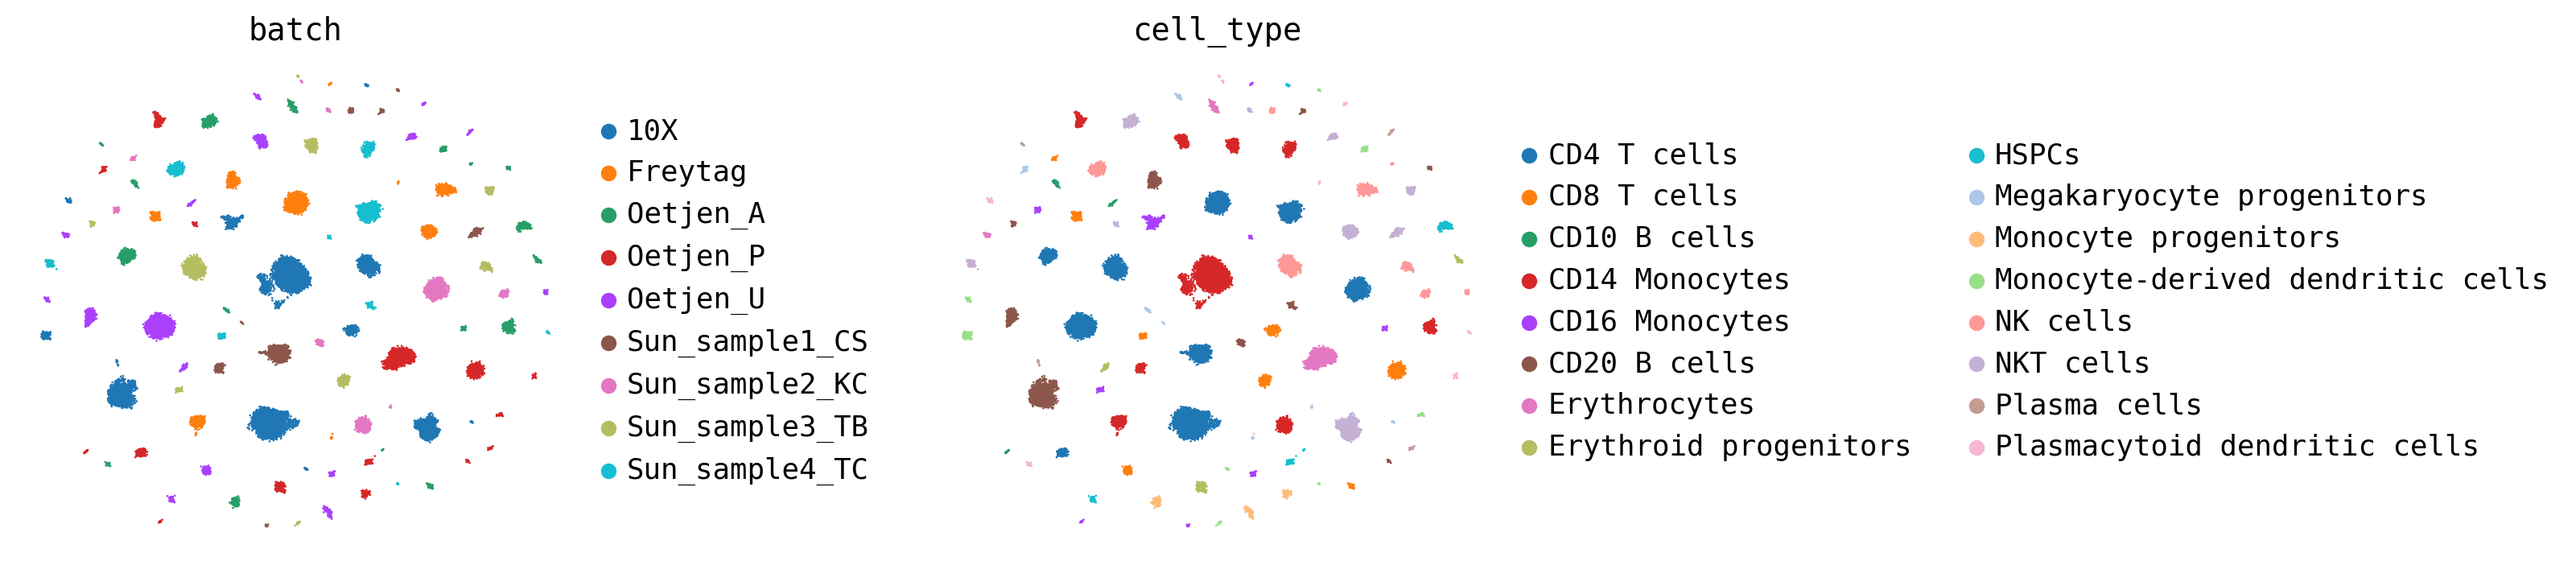

In [ ]:
# @title latent: basal + cell_type + batch
ad = output_batch['latent_z']
sc.pp.neighbors(ad)
sc.tl.umap(ad)

sc.pl.umap(ad,
        color=['batch', 'cell_type'],
        frameon=False,
        wspace=0.5)

         Falling back to preprocessing with `sc.pp.pca` and default params.


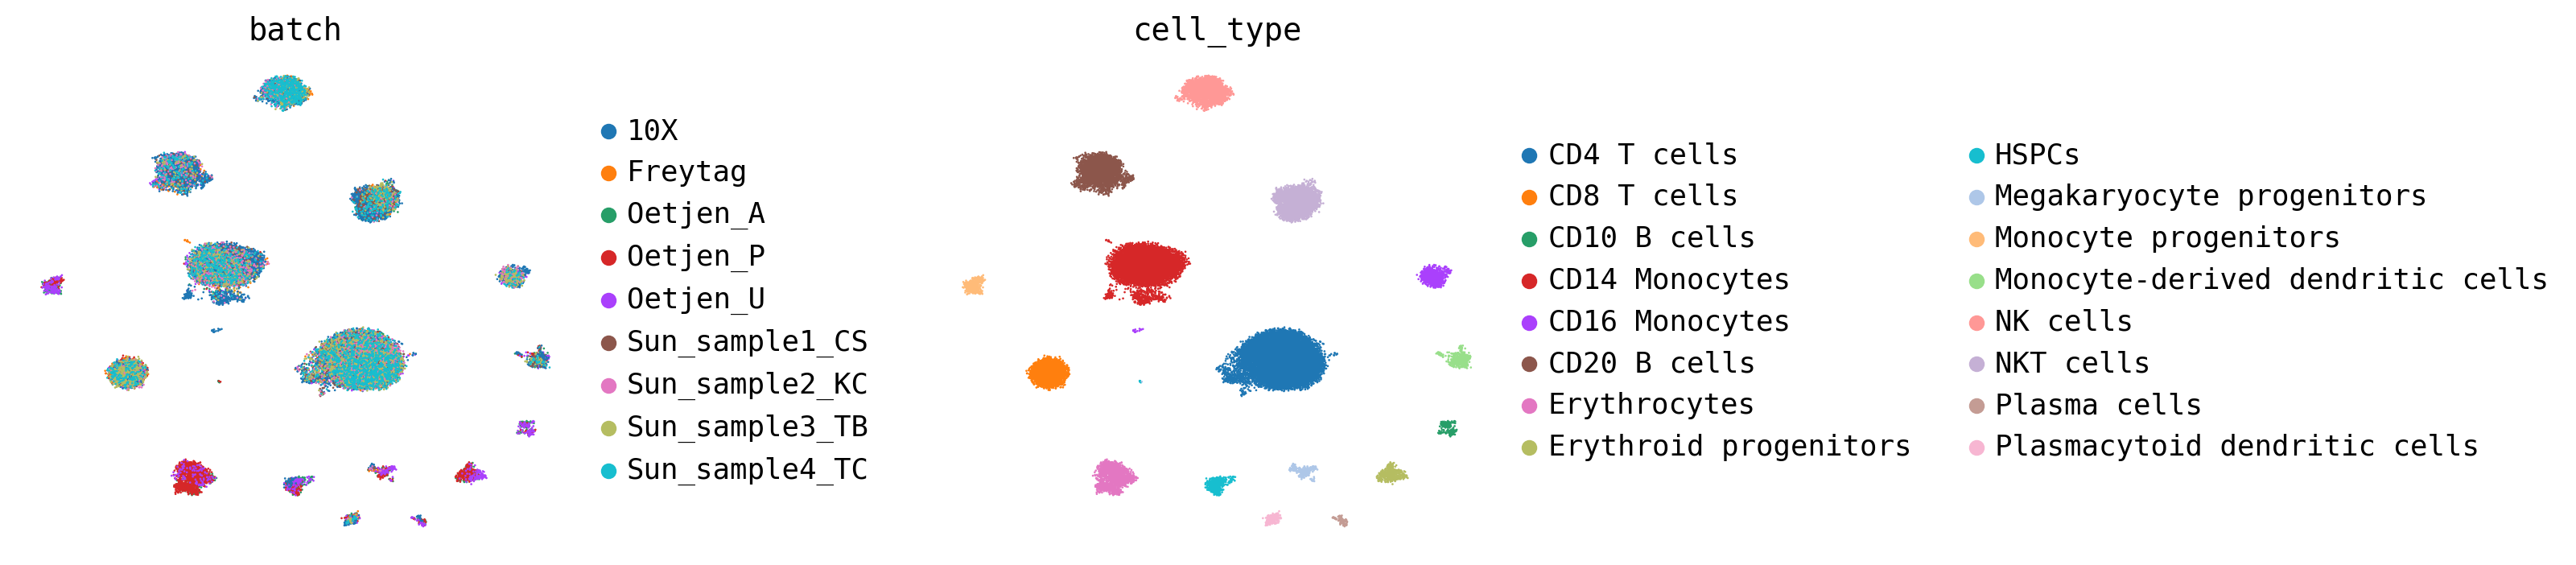

In [ ]:
#@title latent: basal + cell_type
ad = output_batch['latent_z_no_pert']
sc.pp.neighbors(ad)
sc.tl.umap(ad)

sc.pl.umap(ad,
        color=['batch', 'cell_type'],
        frameon=False,
        wspace=0.5)

         Falling back to preprocessing with `sc.pp.pca` and default params.


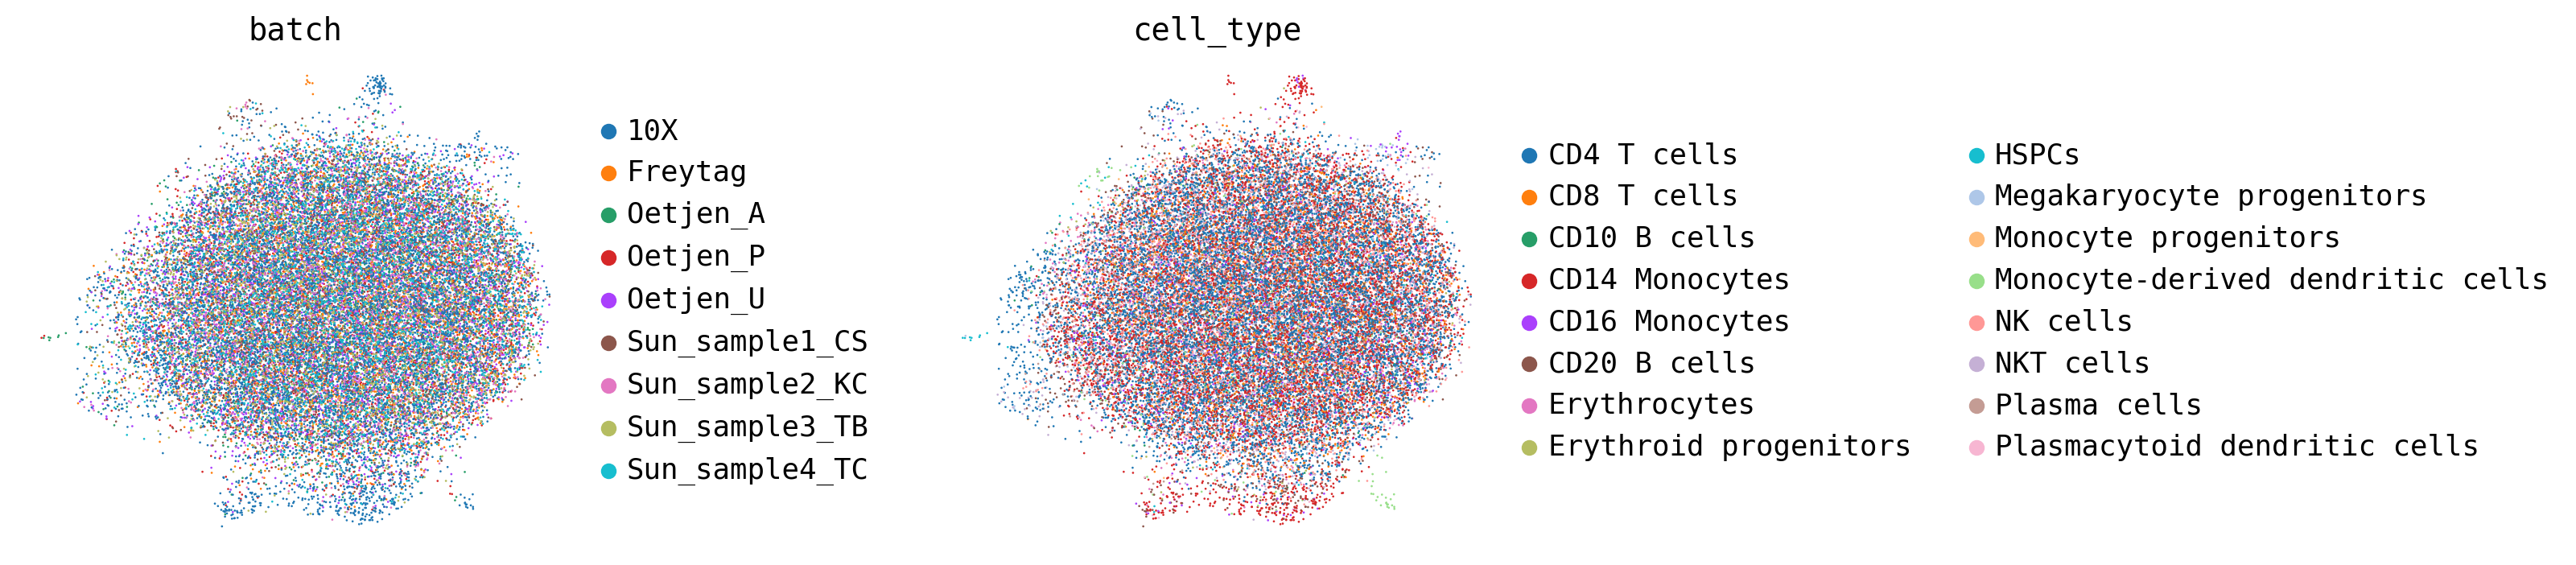

In [ ]:
#@title latent: basal
ad = output_batch['latent_z_basal']

sc.pp.neighbors(ad)
sc.tl.umap(ad)

sc.pl.umap(ad,
        color=['batch', 'cell_type'],
        frameon=False,
        wspace=0.5)

### **Most Important** --> Now we visualize reconstructed gene expressions using UMAP in different conditions:

         Falling back to preprocessing with `sc.pp.pca` and default params.


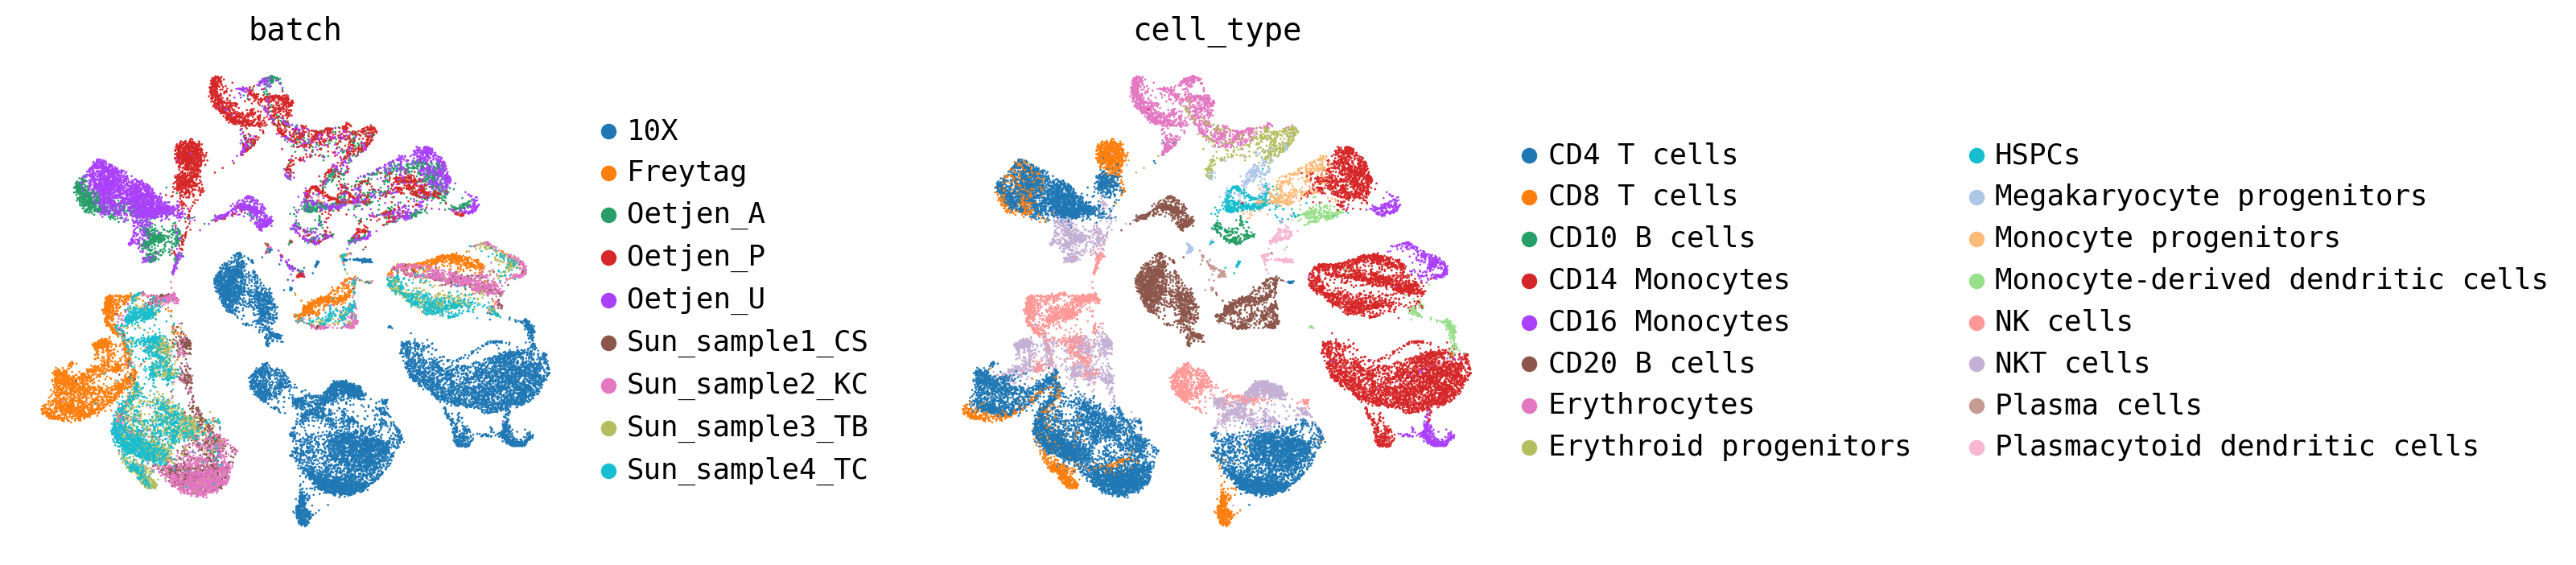

In [ ]:
#@title Gene Expression Reconstruction: basal + cell_type + batch (contains batch effect)
ad = output_batch['latent_x_pred']

sc.pp.log1p(ad)

sc.pp.neighbors(ad)
sc.tl.umap(ad)

sc.pl.umap(ad,
        color=['batch', 'cell_type'],
        frameon=False,
        wspace=0.5)

         Falling back to preprocessing with `sc.pp.pca` and default params.


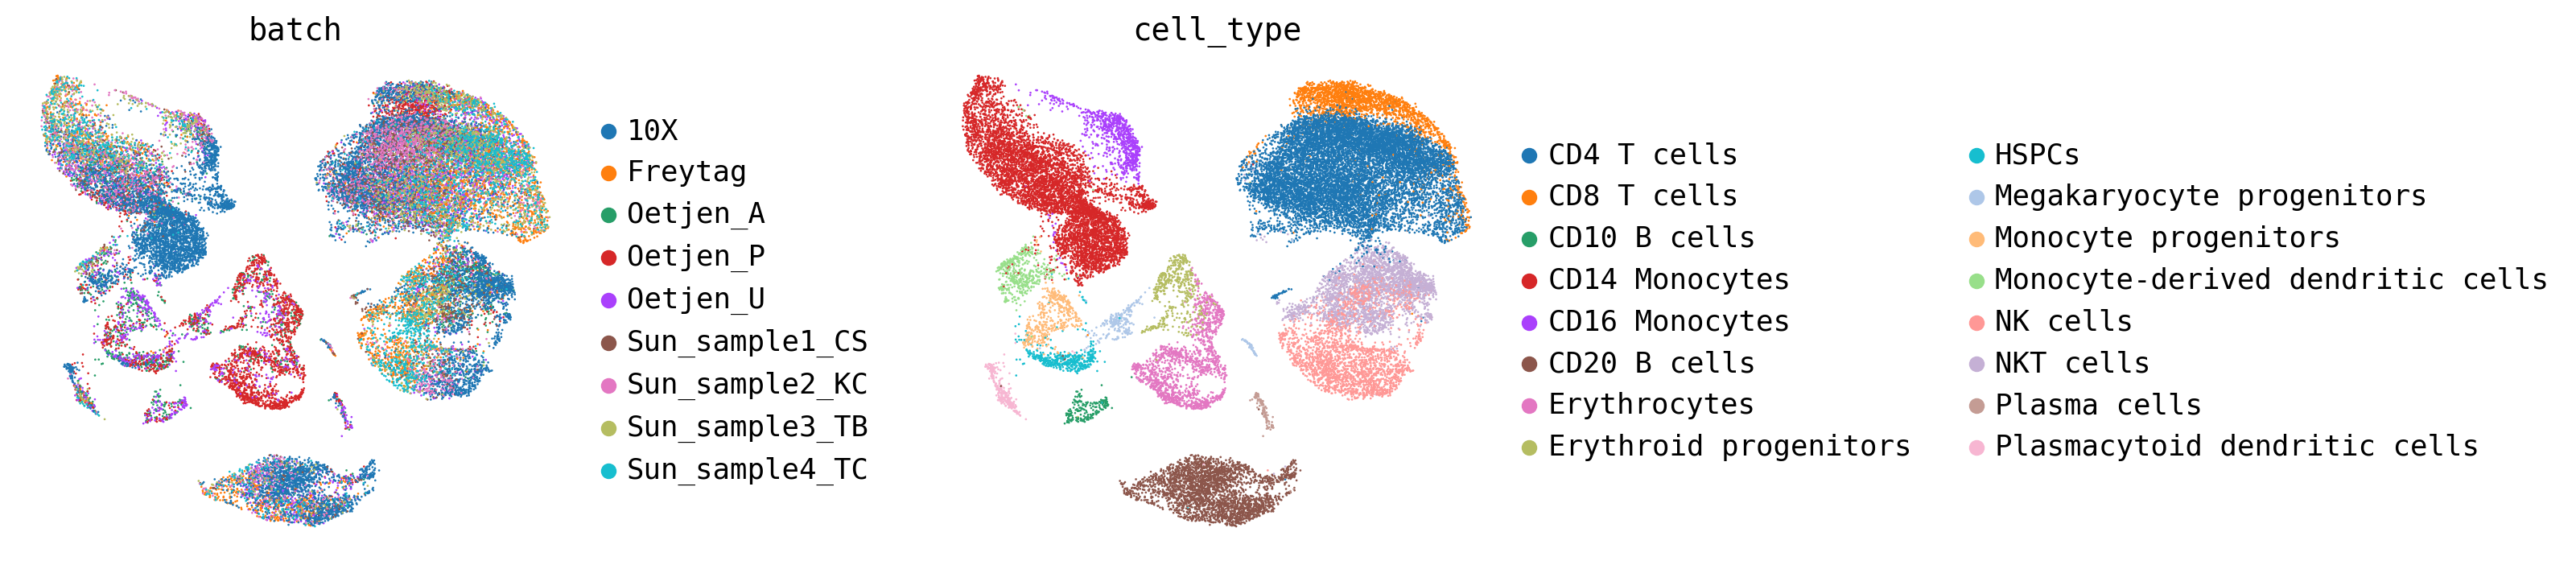

In [ ]:
#@title Gene Expression Reconstruction: basal + cell_type (batch effect removed)
ad = output_no_batch['latent_x_pred']

sc.pp.log1p(ad)

sc.pp.neighbors(ad)
sc.tl.umap(ad)

sc.pl.umap(ad,
        color=['batch', 'cell_type'],
        frameon=False,
        wspace=0.5)

As you can see, we have succesfully reconstructed the gene expression space, removing the batch effect using CPA. We can now use the batch effect removed reconstructed gene expressions for further analysis in our work.